In [1]:
%load_ext autoreload
%autoreload 2

# Modules for graphs
import community
import networkx as nx

# Module for embedding an image
from IPython.display import Image

# Modules for matrix computations and plotting results
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Modules for sparse matrices and eigenvectors
from scipy.sparse import diags
from scipy.sparse.linalg import eigs

In [2]:
def get_random_graph(n_nodes, n_edges):
    """
    Generates a random graph with a specified number of nodes and edges.
    Args:
        n_nodes: Integer specifying the number of nodes in the graph.
        n_edges: Integer specifying the number of edges in the graph.
    Returns:
        nx: A networkx object containing the graph.
    """
    G = nx.gnm_random_graph(n_nodes, n_edges)
    return G

In [3]:
def compute_node_importance(n_nodes, n_communities, eig_vectors):
    """
    Computes node importance using a centrality-based metric which uses the eigenvectors of the adjacency matrix.
    Args:
        n_nodes: Number of nodes in the graph.
        n_communities: Number of communities estimated.
        eig_vectors: np.ndarray of size n x c where n is number of nodes and c is the number of communities.
        The eigenvectors are computed from the adjacency matrix and are stored as columns.
    Returns: 
        np.array: A numpy array containing the node importance score normalized by the
        number of communities.
    """
    p_k = [0] * n_nodes
    I = [0] * n_nodes
    for k in range(n_nodes):
        for i in range(n_communities):
            p_k[k] += eig_vectors[k, i]**2/np.sum(eig_vectors[:, i]**2)
        I[k] = p_k[k]/n_communities
    return np.array(I)

def compute_w_score(n_communities, eig_vectors):
    """
    Computes a score for each node (aka w-score) that can be used to detect if the node is a bridge node.
    Args:
        n_communities: Number of communities estimated.
        eig_vectors: np.ndarray of size n x c where n is number of nodes and c is the number of communities.
        The eigenvectors are computed from the graph laplacian matrix and are stored as columns.
    Returns: 
        np.array: A numpy array containing the w-score normalized by the number of communities and the 
        second array contains unnormalized w-score.
    """
    b_index = np.real(eig_vectors**2).sum(axis=1)
    w_score = b_index/n_communities
    return w_score

In [4]:
def get_graph_laplacian(A):
    """
    Compute laplacian matrix using the adjacency matrix.
    Args:
        A: Scipy sparse matrix containing the adjacency matrix.
    Returns:
        scipy.sparse.matrix: Laplacian matrix.
    """
    A_degree = diags(np.array(A.sum(axis=0), dtype="int32"), offsets=[0])
    L = -A + A_degree
    return L

## Example 1: 

This example represents the undirected graph generated in Figure 1 of Yang et. al. (2011). The paper introduces two indices `I` and `w-score` for measuring node importance. The paper distinguishes two kinds of important nodes: (1) community core and (2) bridge node. The community core is a node which makes the community structure fuzzy if removed from the graph, and a bridge node is a node whose removal will make the community structure clear. 

In the graph shown below, nodes `1` and `8` are community cores and node `15` is a bridge node as it acts as a bridge between the two communities.

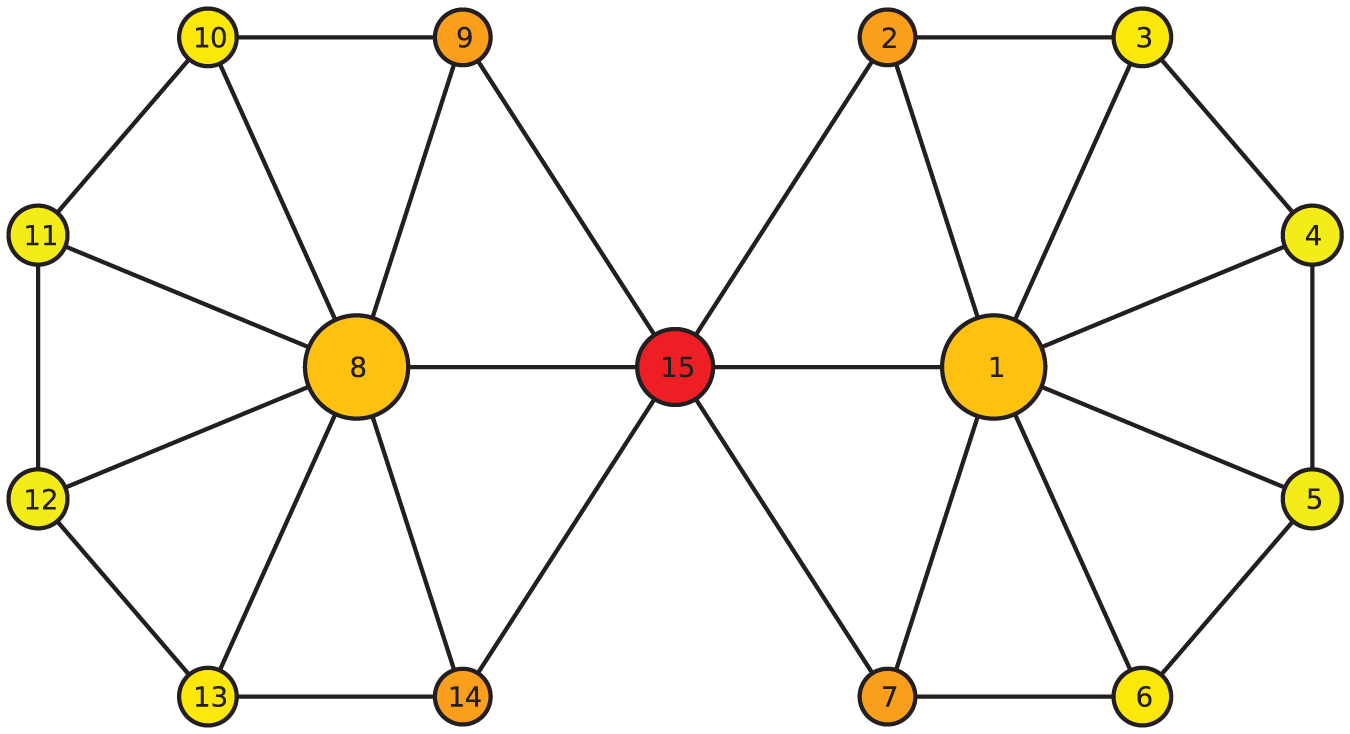

In [5]:
Image("Example_1.png", width=700, height=700)

In [6]:
# Create a networkx graph object
G = nx.Graph()

In [7]:
# Add nodes to empty graph
G.add_nodes_from(np.arange(1, 16))

In [8]:
# Add undirected edges to create graph shown in Example 1
G.add_edges_from([(1,2),(1,3),(1,4),(1,5),(1,6),(1,7),(1,15)])
G.add_edges_from([(2,3),(3,4),(4,5),(5,6),(6,7),(7,15),(15,2)])
G.add_edges_from([(8,9),(8,10),(8,11),(8,12),(8,13),(8,14),(8,15)])
G.add_edges_from([(9,10),(10,11),(11,12),(12,13),(13,14),(9,15),(14,15)])

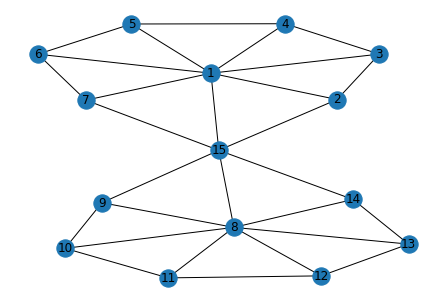

In [9]:
nx.draw(G, with_labels=True)

In [10]:
# Run community detection algorithm on G
partition = community.best_partition(G)

In [11]:
n_communities = len(set(partition.values()))

In [12]:
print(f"Number of communities in G: {n_communities}")

Number of communities in G: 2


In [13]:
# Create adjacency matrix of graph G
A = nx.adjacency_matrix(G)

In [14]:
# Create laplacian matrix
L = get_graph_laplacian(A)

In [15]:
# Compute eigenvalues and eigenvectors of the adjacency matrix A
adj_eig_vals, adj_eig_vecs = eigs(A.toarray().astype(float), k=n_communities, which='LR')

In [16]:
# Compute eigenvalues and eigenvectors of the laplacian matrix L
laplace_eig_vals, laplace_eig_vecs = eigs(L.toarray().astype(float), k=n_communities, which='SR')

In [17]:
# Compute node importance index I using the eigenvectors of the adjacency matrix
I = compute_node_importance(G.number_of_nodes(), n_communities, np.real(adj_eig_vecs))

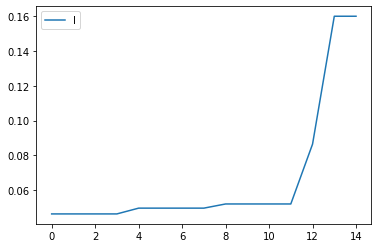

In [18]:
plt.plot(np.sort(I), label='I')
plt.legend(loc='upper left')
plt.show()

In [19]:
# Compute node importance score w-score using the eigenvectors of the laplacian matrix
w_score = compute_w_score(n_communities, np.real(laplace_eig_vecs))

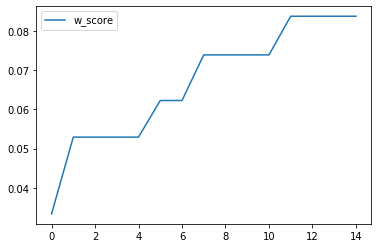

In [20]:
plt.plot(np.sort(w_score), label='w_score')
plt.legend(loc='upper left')
plt.show()

In [21]:
nodes_importance = np.concatenate([np.arange(1, 16).astype(int).reshape(-1, 1), I.reshape(-1, 1), 
                                   w_score.reshape(-1, 1)], axis=1)
df = pd.DataFrame(nodes_importance, columns=['Node', 'I', 'w_score'])

In [22]:
df

,Node,I,w_score
0,1.0,0.159835,0.062254
1,2.0,0.046480,0.052915
2,3.0,0.049791,0.073884
3,4.0,0.052187,0.083741
4,5.0,0.052187,0.083741
5,6.0,0.049791,0.073884
6,7.0,0.046480,0.052915
7,8.0,0.159835,0.062254
8,9.0,0.046480,0.052915
9,10.0,0.049791,0.073884


## Example 2

This example simulates a random graph containing 7000+ nodes and 128k edges that represents the network in Pham et. al. (2019). The purpose of this example is to test the feasibility of computing node importance indices `I` and `w-score` on a graph as big as the network used in Pham et. al. (2019). The steps for computing `I` and `w-score` are the same as that in Example 1.

In [ ]:
G = get_random_graph(7824, 128000)

In [ ]:
G.number_of_nodes()

In [ ]:
# Run community detection algorithm on G
partition = community.best_partition(G)

In [ ]:
n_communities = len(set(partition.values()))

In [ ]:
n_communities

In [ ]:
# Create adjacency matrix
A = nx.adjacency_matrix(G)

In [ ]:
# Create laplacian matrix
L = get_graph_laplacian(A)

In [ ]:
# Compute eigenvalues and eigenvectors of the adjacency matrix
adj_eig_vals, adj_eig_vecs = eigs(A.toarray().astype(float), k=n_communities, which='LR')

In [ ]:
# Compute eigenvalues and eigenvectors of the laplacian matrix
laplace_eig_vals, laplace_eig_vecs = eigs(L.toarray().astype(float), k=n_communities, which='SR')

In [ ]:
# Compute node importance index I using the eigenvectors of the adjacency matrix
I, p_k = compute_node_importance(G.number_of_nodes(), n_communities, np.real(adj_eig_vecs))

In [ ]:
plt.plot(np.sort(p_k), label='p_k')
plt.plot(np.sort(I), label='I')
plt.legend(loc='upper left')
plt.show()

In [ ]:
# Compute node importance score w-score using the eigenvectors of the laplacian matrix
w_score, b_index = compute_w_score(n_communities, np.real(laplace_eig_vecs))

In [ ]:
plt.plot(np.sort(w_score), label='w_score')
plt.plot(np.sort(b_index), label='b index')
plt.legend(loc='upper left')
plt.show()